In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import figure 

keras = tf.keras

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [7]:
'''x0 = [[0],[0]]
P0 = [[0, 0], [0, 0]]
dt = 0.1
sigma_a = 0.05
sigma_z = 0.1

#tf.reset_default_graph()

with tf.compat.v1.variable_scope('constants'):
    F = tf.constant([[1, dt],[0, 1]], dtype=tf.float32)
    G = tf.constant([[dt**2/2], [dt]], dtype=tf.float32)
    Q = tf.matmul(G, G, transpose_b=True) * sigma_a**2
    H = tf.constant([[1,0]], dtype=tf.float32)
    R = tf.constant(sigma_z**2, dtype=tf.float32)

with tf.compat.v1.variable_scope('model'):
    with tf.compat.v1.variable_scope('state'):
        x = tf.Variable(x0, dtype=tf.float32)
    
    with tf.compat.v1.variable_scope('noise'):
        w = G*tf.compat.v1.random_normal([1], mean=0, stddev=sigma_a)
        
    with tf.compat.v1.variable_scope('update_model'):
        update_model = x.assign(tf.matmul(F,x) + w)
    
with tf.compat.v1.variable_scope('observation'):
    v = tf.compat.v1.random_normal([1], mean=0, stddev=sigma_z)
    z = tf.matmul(H,x) + v

with tf.compat.v1.variable_scope('kalman_filter'):
    with tf.compat.v1.variable_scope('model_estimate'):
        xhat = tf.Variable(x0, dtype=tf.float32)
        P = tf.Variable(P0, dtype=tf.float32)

    with tf.compat.v1.variable_scope('predict'):
        predict_xhat = xhat.assign(tf.matmul(F,xhat))
        predict_P = P.assign(tf.matmul(F,tf.matmul(P,F, transpose_b=True)) + Q)
        
    with tf.compat.v1.variable_scope('update_estimation'):
        y1 = z - tf.matmul(H,xhat)
        S = R + tf.matmul(H,tf.matmul(P,H, transpose_b=True))
        K = tf.matmul(tf.matmul(P,H, transpose_b=True) , tf.linalg.inv(S))
        update_xhat = tf.compat.v1.assign_add(xhat, tf.matmul(K,y1))
        delta_P = tf.matmul(K,tf.matmul(H,P))
        update_P = tf.compat.v1.assign_sub(P, delta_P)
        y2 = z - tf.matmul(H,xhat)
    
with tf.compat.v1.Session() as sess:    
    sess.run(tf.compat.v1.global_variables_initializer())
    #summary_writer = tf.summary.FileWriter('logdir/', sess.graph)
    
    N = 200

    t = [i*dt for i in range(N)]
    model = np.array([x0]*N, dtype=np.float32)
    estimate1 = np.array([x0]*N, dtype=np.float32)
    error1 = np.array([P0]*N, dtype=np.float32)
    estimate2 = np.array([x0]*N, dtype=np.float32)
    error2 = np.array([P0]*N, dtype=np.float32)
    observations = np.array([0]*N, dtype=np.float32)
    for i in range(1,N):
        model[i], estimate1[i] , error1[i], estimate2[i], error2[i], observations[i] = sess.run([update_model, predict_xhat, predict_P, update_xhat, update_P, z])

#plot

plt.figure(num=None, figsize=(14, 6))

plt.subplot(1, 2, 1)

plt.fill_between(t,estimate2[:,0,0]+np.sqrt(error2[:,0,0]),estimate2[:,0,0]-np.sqrt(error2[:,0,0]), color = [0.5,0.75,0.75,.5])
plt.plot(t, model[:,0,0],  color='k', linewidth=2.0)
plt.plot(t, observations, color='r', marker='.', linestyle='None')

plt.ylabel('Position', fontsize=18)
plt.xlabel('Time', fontsize=18)

plt.subplot(1, 2, 2)
plt.fill_between(t,estimate2[:,1,0]+np.sqrt(error2[:,1,1]),estimate2[:,1,0]-np.sqrt(error2[:,1,1]), color = [0.5,0.75,0.75,.5])
plt.plot(t, model[:,1,0],  color='k', linewidth=2.0)

plt.ylabel('Velocity', fontsize=18)
plt.xlabel('Time', fontsize=18)

plt.savefig('simple.png') '''

"x0 = [[0],[0]]\nP0 = [[0, 0], [0, 0]]\ndt = 0.1\nsigma_a = 0.05\nsigma_z = 0.1\n\n#tf.reset_default_graph()\n\nwith tf.compat.v1.variable_scope('constants'):\n    F = tf.constant([[1, dt],[0, 1]], dtype=tf.float32)\n    G = tf.constant([[dt**2/2], [dt]], dtype=tf.float32)\n    Q = tf.matmul(G, G, transpose_b=True) * sigma_a**2\n    H = tf.constant([[1,0]], dtype=tf.float32)\n    R = tf.constant(sigma_z**2, dtype=tf.float32)\n\nwith tf.compat.v1.variable_scope('model'):\n    with tf.compat.v1.variable_scope('state'):\n        x = tf.Variable(x0, dtype=tf.float32)\n    \n    with tf.compat.v1.variable_scope('noise'):\n        w = G*tf.compat.v1.random_normal([1], mean=0, stddev=sigma_a)\n        \n    with tf.compat.v1.variable_scope('update_model'):\n        update_model = x.assign(tf.matmul(F,x) + w)\n    \nwith tf.compat.v1.variable_scope('observation'):\n    v = tf.compat.v1.random_normal([1], mean=0, stddev=sigma_z)\n    z = tf.matmul(H,x) + v\n\nwith tf.compat.v1.variable_scope('k

In [8]:
class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), 
            (I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)

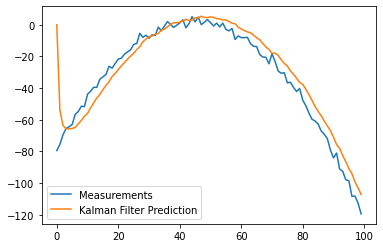

In [9]:
#def example():
dt = 1.0/60
F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
H = np.array([1, 0, 0]).reshape(1, 3)
Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
R = np.array([0.5]).reshape(1, 1)

x = np.linspace(-10, 10, 100)
measurements = - (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)

kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
predictions = []

for z in measurements:
    predictions.append(np.dot(H,  kf.predict())[0])
    kf.update(z)

import matplotlib.pyplot as plt
plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.plot(range(len(predictions)), np.array(predictions), label = 'Kalman Filter Prediction')
plt.legend()
plt.show()

#if __name__ == '__main__':
    #example()

In [10]:
x

array([-10.        ,  -9.7979798 ,  -9.5959596 ,  -9.39393939,
        -9.19191919,  -8.98989899,  -8.78787879,  -8.58585859,
        -8.38383838,  -8.18181818,  -7.97979798,  -7.77777778,
        -7.57575758,  -7.37373737,  -7.17171717,  -6.96969697,
        -6.76767677,  -6.56565657,  -6.36363636,  -6.16161616,
        -5.95959596,  -5.75757576,  -5.55555556,  -5.35353535,
        -5.15151515,  -4.94949495,  -4.74747475,  -4.54545455,
        -4.34343434,  -4.14141414,  -3.93939394,  -3.73737374,
        -3.53535354,  -3.33333333,  -3.13131313,  -2.92929293,
        -2.72727273,  -2.52525253,  -2.32323232,  -2.12121212,
        -1.91919192,  -1.71717172,  -1.51515152,  -1.31313131,
        -1.11111111,  -0.90909091,  -0.70707071,  -0.50505051,
        -0.3030303 ,  -0.1010101 ,   0.1010101 ,   0.3030303 ,
         0.50505051,   0.70707071,   0.90909091,   1.11111111,
         1.31313131,   1.51515152,   1.71717172,   1.91919192,
         2.12121212,   2.32323232,   2.52525253,   2.72

In [6]:
#series_21 = np.loadtxt('/content/user_2000.csv', delimiter=',')
#series_21 = np.loadtxt('user_sinr_shad_stdev4.csv', delimiter=',')
series_21 = np.loadtxt('sinr_correl_shad8dB_10k.csv', delimiter=',')
#series_21 = sinr_all2[:TIME_INST,0:21, 2]
series_csv = pd.read_csv('sinr_correl_shad6dB_2k.csv')

print(np.shape(series_21))
time = np.arange(len(series_21))
total_time_steps = len(series_21)

print(np.shape(time))

OSError: sinr_correl_shad8dB_10k.csv not found.